<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Notebook for Pyro implementation of learning an Ornstein Uhlenbeck process
</div>

(Ref : ch11. from Sarkka and Solin "Applied Stochastic Differential Equations")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from tqdm import tqdm
import torchsde

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    # if using a GPU (CUDA) and num_chains > 1
    torch.multiprocessing.set_start_method('spawn', force=True)
else:
    device = torch.device('cpu')
    
# NB Warning : setting the default_device to CUDA creates a device conflict
# when using a DataLoader, as it uses a CPU-generator for shuffling
torch.set_default_device(device)
print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
0 : Create sample path from Ornstein-Uhlenbeck
</div>

\begin{align}
dX_t &= - \lambda X_t dt + \sigma dB_t \\
X_0 &= x_0
\end{align}

### Ground Truth Parameters

In [4]:
lambda_gt = 0.5  # Rate of mean reversion
sigma_gt = 1.0  # Volatility parameter

In [5]:
# create an Ornstein Uhlenbeck SDE model:
# dX_t = theta * (mu - X_t) dt + sigma dW_t
# theta, mu, sigma scalar parameters
# W_t is a standard 1D Brownian motion

# SDE are instantiated as subclasses of nn.Module

class OUSDE(nn.Module):
    def __init__(self, lambda_, sigma):
        
        # noise type can take 4 values : "diagonal", "general", "additive", "scalar"
        # here we use "diagonal" : the diffusion function g(t,y) is an element wise function,
        # its output has the same shape as y, ie (batch_size, state_size)
        
        # sde_type can be "ito" or "stratonovich"
        # we use "ito" here. The available methods for computation are Euler(-Maruyama), Milstein, SRK.
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
        # we register the parameters so we can save them. But we will not train them.
        self.register_buffer("lambda_", torch.tensor(lambda_))
        self.register_buffer("sigma", torch.tensor(sigma))

    # DRIFT FUNCTION
    # inputs are:
    # - t : a tensor of shape (1,) representing the time stamps
    # - y : a tensor of shape (batch_size, state_size) representing the current state
    # outputs:
    # - a tensor of shape (batch_size, state_size) representing the drift at time t and state y
    # note : the functions f and g must be able to handle inputs of shape (batch_size, state_size)
    # for any batch_size >= 1
    def f(self, t, y):
        return -self.lambda_ * y
    
    # DIFFUSION FUNCTION
    # inputs are:
    # - t : a tensor of shape (1,) representing the time stamps
    # - y : a tensor of shape (batch_size, state_size) representing the current state
    # outputs:
    # - a tensor of shape (batch_size, state_size) representing the diffusion at time t and state y
    # (NB : generally, the output of g is of shape (batch_size, state_size, brownian_size) when noise_type is "general")
    def g(self, t, y):
        return self.sigma * torch.ones_like(y)
    
    def __repr__(self):
        msg = f'OU_SDE with parameter lambda = {self.lambda_:.2e} and sigma = {self.sigma:.2e}'
        return msg
    
    
model = OUSDE(lambda_=lambda_gt, sigma=sigma_gt).to(device)

print(model)

OU_SDE with parameter lambda = 5.00e-01 and sigma = 1.00e+00


In [6]:
N_POINTS = 100 # number of points in each path
N_PATHS = 1 # number of paths to sample

t_start = 0.0
t_end = 10.0

ts = torch.linspace(t_start, t_end, N_POINTS).to(device)  # time stamps where we want the solution, between 0 and 1
print(f"Time stamps shape : {ts.shape}")  # shape (N_POINTS,)
y_start = 0.0  # initial condition
y0 = torch.full((N_PATHS, 1), y_start).to(device)  # initial condition 0.25, shape (batch_size=N_PATHS, state_size=1)
print(f"Initial condition shape : {y0.shape}")  # shape (N_PATHS, 1)

# now, we call sdeint to solve the SDE
# NB : we can use the adjoint method by calling sdeint_adjoint instead of sdeint
# method can be "euler", "milstein", "srk" for sde_type="ito"
# dt is the step size used by the solver (smaller dt -> more accurate but slower). By default, dt=1e-3

with torch.no_grad():  # we don't need gradients for this demo
    ys = torchsde.sdeint(model, y0, ts, method="euler", dt=1e-3)  # shape (N_POINTS, N_PATHS, 1)
print(f"Computed solution samples : {ys.size()}")

Time stamps shape : torch.Size([100])
Initial condition shape : torch.Size([1, 1])
Computed solution samples : torch.Size([100, 1, 1])


In [7]:
# sanity check on the time scale

print(f"Delta t = {(t_end - t_start) / N_POINTS:.3e}")
print(f"Time constant (1/lambda) = {1/ lambda_gt:.3e}")

ldt = (t_end - t_start) / N_POINTS * lambda_gt
print(f"lambda . Delta_t = {ldt}")

Delta t = 1.000e-01
Time constant (1/lambda) = 2.000e+00
lambda . Delta_t = 0.05


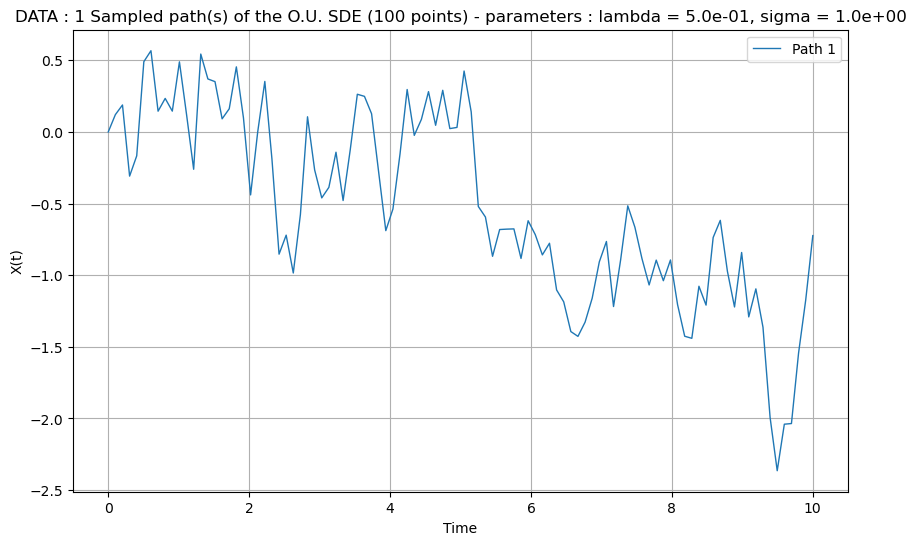

In [8]:
def plot_ousde_samples(ts, ys, model, title=None):
    """
    Utility functions to plot the sampled SDE solutions
    """
    fig, ax = plt.subplots(figsize=(10,6))
    n_points = ts.size()[0]
    n_paths = ys.size()[1]
    
    for i, y in enumerate(ys.permute(1,0,2)):  # iterate over paths
        ax.plot(ts.detach().cpu().numpy(), y.detach().cpu().numpy(), lw=1, alpha=1.0, label=f'Path {i+1}' if i<10 else None)  # plot each path
    
    if title is None:
        title = f"DATA : {n_paths} Sampled path(s) of the O.U. SDE ({n_points:.0f} points) - parameters : lambda = {model.lambda_.item():.1e}, sigma = {model.sigma.item():.1e}"
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.legend()
    ax.grid()
        
    return fig, ax

fig, ax = plot_ousde_samples(ts, ys, model)
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
1 : Maximum Likelihood (Point Estimates)
</div>

### Analytical Solution for Maximum Likelihood Estimation

Analytical solution:

\begin{align}
X_t &= e^{-\lambda t}X_0 + \sigma \int_{0}^{t}e^{\lambda (s-t)}dB_s \\
X_0 &= x_0
\end{align}

Therefore:
\begin{align}
X_t \vert X_s \sim \mathcal{N}\left( e^{-\lambda (t-s)}X_s \,;\, \frac{\sigma^2}{2 \lambda} (1 - e^{-2 \lambda (t-s)})\right)
\end{align}

Likelihood (assuming constant time intervals : $\Delta t = t_{k+1}-t_k$)

\begin{align}
- \log{p(x_{1:N})} &= \frac{N}{2} \log{\Sigma} + \frac{1}{2 \Sigma} \sum_{k=0}^{N-1} (x_{k+1} - a x_k)^2 + \text{cte}
\end{align}
with:
\begin{align}
a &= e^{-\lambda \Delta t} \\
\Sigma &= \frac{\sigma^2}{2 \lambda} (1-e^{-2 \lambda \Delta t})
\end{align}

MLE:

\begin{align}
\lambda_{ML} &= - \frac{1}{\Delta t} \log{\frac{\sum_{k=0}^{T-1} x_k x_{k+1}}{\sum_{k=0}^{T-1} x_k^2}} \\
\sigma_{ML}^2 &= \frac{1}{N} \left( \frac{2 \lambda_{ML}}{1 - \exp{(-2 \lambda_{ML} \Delta t)}} \right) \sum_{k=0}^{T-1} \left( x_{k+1} - \exp{(-\lambda_{ML} \Delta t)} x_k\right) ^2
\end{align}

In [9]:
delta_t = (t_end - t_start) / (N_POINTS - 1)  # time step between points

for i, x in enumerate(ys.permute(1,0,2)):  # iterate over paths
    # get path data
    x_ = x.squeeze(-1)  # shape (N_POINTS,)
    # compute theta ML estimate
    s1 = np.sum(x_[:-1].cpu().numpy() * x_[1:].cpu().numpy())  # sum over time points
    s2 = np.sum(x_[:-1].cpu().numpy()**2)  # sum over time points
    lambda_ml = - (1/delta_t) * np.log(s1 / s2)
    print(f"Estimated lambda ML for path {i+1} : {lambda_ml:.3e} vs ground truth : {lambda_gt:.3e}")
    # autre méthode to check
    s3 = np.sum([x_[k].cpu().numpy()*x_[k+1].cpu().numpy() for k in range(x_.shape[0]-1) ])
    s4 = np.sum([x_[k].cpu().numpy()**2 for k in range(x_.shape[0]-1)])
    lambda_est_2 = -1/(delta_t)*np.log(s3/s4)
    # print(f"Autre méthode : lambda_est = {lambda_est_2:.4e}")
    # compute sigma ML estimate
    s3 = np.sum((x_[1:].cpu().numpy() - np.exp(-lambda_ml * delta_t) * x_[:-1].cpu().numpy())**2)  # sum over time points
    sigma_ml = np.sqrt(s3 / N_POINTS / (1 - np.exp(-2 * lambda_ml * delta_t)) * 2 * lambda_ml)
    print(f"Estimated sigma ML for path {i+1} : {sigma_ml:.3e} vs ground truth : {sigma_gt:.3e}")

Estimated lambda ML for path 1 : 7.132e-01 vs ground truth : 5.000e-01
Estimated sigma ML for path 1 : 1.028e+00 vs ground truth : 1.000e+00


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 40px; color: black; font-weight: bold;">
Using Pyro
</div>

We put uninformative priors on $\lambda > 0, \sigma > 0$ and $x_0$

\begin{align}
\log{\lambda} &\sim \mathcal{N}(0.0, 1.0) \\
\log{\sigma} &\sim \mathcal{N}(0.0, 1.0) \\
x_0 &\sim \mathcal{N}(0.0, 1.0)
\end{align}

and compute the likelihood as (seen above, but this time allowing for changing time intervals):

\begin{align}
X_{t_{k+1}} \vert X_{t_k} &\sim \mathcal{N}\left( e^{-\lambda (t_{k+1}-t_k)}X_{t_k} ; \frac{\sigma^2}{2 \lambda} (1 - e^{-2 \lambda (t_{k+1}-t_k)})\right) \\
p(x_{k+1} \vert x_k) &= \frac{1}{\sqrt{2\pi \sigma_k^2}} \exp{\left( -\frac{1}{\sigma_k^2}(x_{k+1} - a_k x_k)^2 \right) }
\end{align}

Which leads to:

\begin{align}
\log{p(x_{1:N})} &= -\frac{1}{2} \sum_{k=0}^{N-1} \log{\sigma_k^2} - \frac{1}{2} \sum_{k=0}^{N-1} \frac{(x_{k+1} - a_k x_k)^2}{\sigma_k^2} + \log{p(x_0)} + \text{cte}
\end{align}
with:
\begin{align}
a_k &= e^{-\lambda (t_{k+1} - t_k)} \\
\sigma_k^2 &= \Sigma_k = \frac{\sigma^2}{2 \lambda} (1-e^{-2 \lambda (t_{k+1} - t_k)})
\end{align}

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Model
</div>

NB : we declare the `model` as a function, not a class, as we aim at doing MCMC sampling with NumPyro in the end.

In [10]:
t = ts
X = ys.squeeze()

print(f'Time stamps : {t.size()}')
print(f'Values : {X.size()}')

Time stamps : torch.Size([100])
Values : torch.Size([100])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
A first model with no observation noise (basically MLE)
</div>

In [11]:
# def pyro_model(t, X=None):
#     # Pyro model to learn parameters
#     # inputs:
#     #   t (torch.tensor) : (N_POINTS,) : this is the tensor of time steps
#     #   X (torch.tensor, optional) : (N_POINTS,) : the tensor of values at times t
    
#     # number of points
#     N = len(t)
    
#     # priors
#     # NB : we posit log_Normal distributions on lambda and sigma for positivity
#     log_lambda = pyro.sample("log_lambda", dist.Normal(0., 1.))  
#     log_sigma = pyro.sample("log_sigma", dist.Normal(0.,1.))
    
#     # this is the prior for x_0 and also the first value for the likelihood calculation
    
#     # compute likelihood
#     lambda_ = torch.exp(log_lambda)
#     sigma = torch.exp(log_sigma)
#     # x_0 prior
#     x0_sd = sigma / torch.sqrt(2 * lambda_)
#     x_current = pyro.sample("x_0", dist.Normal(0.,x0_sd), obs=X[0])
#     # for transition
#     a = torWe will use a modified model with $a_k, \sigma_k^2$ as random variablesch.exp(-lambda_ * (t[1:] - t[:-1]))   # shape (N-1,)
#     sigma_2 = sigma**2 / (2 * lambda_) * (1 - torch.exp(-2 * lambda_ * (t[1:] - t[:-1])))  # shape (N-1, )
    
#     # likelihood
#     for i in pyro.markov(range(1,N)):
#         x_next = pyro.sample(
#             f"x_{i}", 
#             dist.Normal( a[i-1] * x_current , torch.sqrt(sigma_2[i-1]) ), obs=X[i])  # no observation noise on top of the latent
#         x_current = x_next

In [12]:
# NB : we need the model in a separate namespace so we can use the GPU for multiple MCMC chains

from pyro_models import pyro_model

MCMC Sampling

In [13]:
# reset the Store parameters
pyro.clear_param_store()

# define the NUTS kernel - takes the generative model itself.
nuts_kernel = NUTS(
    model=pyro_model,
    jit_compile=True, # True for speed, False for debugging
)

# define a MCMC sampler with the above kernel
# does NOT use the model. This is merely the executor of the MCMCKernel
N_MCMC_SAMPLES = 1000
N_BURNIN = 2000

MCMC_runner = MCMC(
    kernel=nuts_kernel,
    num_samples=N_MCMC_SAMPLES,
    warmup_steps=N_BURNIN,
    num_chains=4,
    initial_params=None
)

# run the sampler
MCMC_runner.run(t,X)

Warmup [1]:   0%|          | 0/3000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/3000 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/3000 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/3000 [00:00, ?it/s]

In [14]:
def display_diag_MCMC(diags):

    # Extract all 'n_eff' tensors for example : number of effective samples from the Markov chains
    n_eff_list = []
    for rv_name, rv_diagnostics in diags.items():
        
        # We only care about n_eff for the parameters we are sampling (weights, biases, sigma)
        # Exclude auxiliary or internal diagnostics if they exist.
        if 'n_eff' in rv_diagnostics and rv_name not in  ['_last_state', 'potential_energy']:
            
            # n_eff might be a tensor if the site is multidimensional (like a weight matrix)
            n_eff_tensor = rv_diagnostics['n_eff']
            
            # Flatten the tensor and add all its elements to our list
            n_eff_list.append(n_eff_tensor.flatten())

    # Concatenate all n_eff tensors into a single 1D tensor
    all_n_eff = torch.cat(n_eff_list)

    # Compute the average and minimum ESS
    average_n_eff = all_n_eff.mean().item()
    min_n_eff = all_n_eff.min().item()

    print(f"Total number of stochastic parameters analyzed: {len(all_n_eff)}")
    print(f"Overall Average Effective Sample Size (ESS): {average_n_eff:.2f}")
    print(f"Minimum Effective Sample Size (ESS): {min_n_eff:.2f}")

In [15]:
# check effective sample size, etc. by getting the dictionnary of results
# The structure is: {'<RV_name>': {'n_eff': tensor, 'r_hat': tensor, ...}, ...}
diags = MCMC_runner.diagnostics()

print(MCMC_runner.summary())
display_diag_MCMC(diags)


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  log_lambda     -0.38      0.51     -0.31     -1.13      0.43   1593.31      1.00
   log_sigma      0.04      0.08      0.04     -0.10      0.15   2081.33      1.00

Number of divergences: 1
None
Total number of stochastic parameters analyzed: 2
Overall Average Effective Sample Size (ESS): 1837.32
Minimum Effective Sample Size (ESS): 1593.31


lambda :
	ground truth : 	5.000e-01
	MLE : 		7.132e-01
	MAP : 		5.482e-01
sigma :
	ground truth : 	1.000e+00
	MLE : 		1.028e+00
	MAP : 		1.034e+00


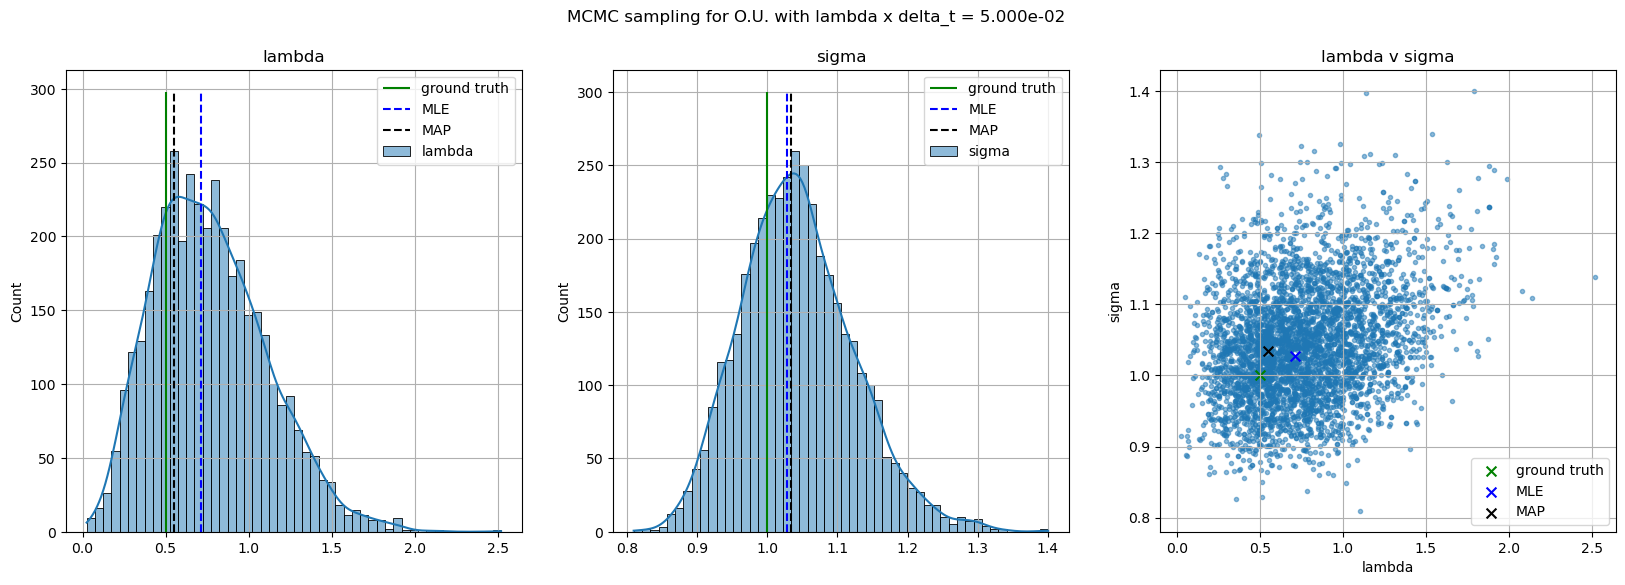

In [16]:
# get samples and analyse
posterior_samples = MCMC_runner.get_samples()

lambda_samples = torch.exp(posterior_samples.get("log_lambda"))
hist_counts, bin_edges = np.histogram(lambda_samples.cpu().numpy(), bins=100)
lambda_map = bin_edges[hist_counts.argmax()]  # approximate MAP

sigma_samples = torch.exp(posterior_samples.get("log_sigma"))
hist_counts, bin_edges = np.histogram(sigma_samples.cpu().numpy(), bins=100)
sigma_map = bin_edges[hist_counts.argmax()]  # approximate MAP

print(f'lambda :')
print(f'\tground truth : \t{lambda_gt:.3e}')
print(f'\tMLE : \t\t{lambda_ml:.3e}')
print(f'\tMAP : \t\t{lambda_map:.3e}')
print(f'sigma :')
print(f'\tground truth : \t{sigma_gt:.3e}')
print(f'\tMLE : \t\t{sigma_ml:.3e}')
print(f'\tMAP : \t\t{sigma_map:.3e}')

fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=3)

sns.histplot(lambda_samples.cpu().numpy(), bins=50, kde=True, label=f'lambda', ax=ax[0])
ymax=ax[0].get_ylim()[1]*1.1
ax[0].vlines(lambda_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
ax[0].vlines(lambda_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
ax[0].vlines(lambda_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
ax[0].set_title(f'lambda')
ax[0].legend()
ax[0].grid()

sns.histplot(sigma_samples.cpu().numpy(), bins=50, kde=True, label=f'sigma', ax=ax[1])
ymax=ax[1].get_ylim()[1]*1.1
ax[1].vlines(sigma_gt, ymin=0, ymax=ymax, color='green', label='ground truth')
ax[1].vlines(sigma_ml, ymin=0, ymax=ymax, color='blue', linestyles='--', label='MLE')
ax[1].vlines(sigma_map, ymin=0, ymax=ymax, color='black', linestyles='--', label='MAP')
ax[1].set_title(f'sigma')
ax[1].legend()
ax[1].grid()

ax[2].scatter(lambda_samples.cpu().numpy(), sigma_samples.cpu().numpy(), marker='.', alpha=0.5)
ax[2].scatter(lambda_gt, sigma_gt, marker='x', s=50.0, color='green', label='ground truth')
ax[2].scatter(lambda_ml, sigma_ml, marker='x', s=50.0, color='blue', label='MLE')
ax[2].scatter(lambda_map, sigma_map, marker='x', s=50.0, color='black', label='MAP')
ax[2].set_title(f'lambda v sigma')
ax[2].set_xlabel('lambda')
ax[2].set_ylabel('sigma')
ax[2].legend()
ax[2].grid()

fig.suptitle(f"MCMC sampling for O.U. with lambda x delta_t = {ldt:.3e}")

plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
A note on whether or not posterior sampling is useful...
</div>

Recall that 

\begin{align}
dX_t &= - \lambda X_t dt + \sigma dB_t \\
X_0 &= x_0
\end{align}

The big take-away is that if
\begin{align}
\lambda \Delta t << 1
\end{align}

Then $(X_t)_{t \geq 0}$ is close to:
\begin{align}
dX_t &\sim \sigma dB_t \\
X_0 &= x_0
\end{align}

That is the observed $X_t$ is close to a **random walk** and it is very difficult to estimate $\lambda$.

The O.U. process becomes indistinguishable from a random walk at that time scale.

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 60px; color: black; font-weight: bold;">
Take-aways
</div>

High-frequency ≠ high information for λ.

If $\lambda \Delta_t << 1$, treat the path as approximately a Wiener process; focus on $\sigma$

To infer $\lambda$ reliably, you need:
- Larger $\Delta t$, or
- Longer total observation window, spanning multiple relaxation times - ie $\lambda \Delta_t \geq 0.1, 0.01$